# **IBMEC - Aula ao Vivo 03**

**Disciplina: Processamento de Áudio e Voz**

**prof: Sérgio Assunção Monteiro, DSc**


https://www.linkedin.com/in/sergio-assun%C3%A7%C3%A3o-monteiro-b781897b/

# **DTW**

In [6]:
!pip install dtaidistance

In [7]:
!pip install dtw

(<Figure size 432x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6a532124d0>,
       dtype=object))

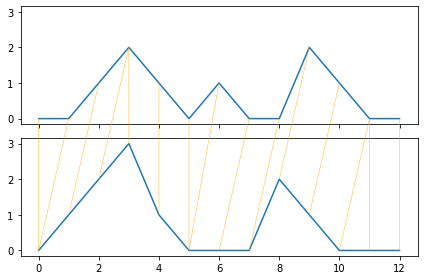

In [8]:
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import numpy as np
s1 = np.array([0., 0, 1, 2, 1, 0, 1, 0, 0, 2, 1, 0, 0])
s2 = np.array([0., 1, 2, 3, 1, 0, 0, 0, 2, 1, 0, 0, 0])
path = dtw.warping_path(s1, s2)
dtwvis.plot_warping(s1, s2, path)

In [9]:
from dtaidistance import dtw
import numpy as np
s1 = np.array([0, 0, 1, 2, 1, 0, 1, 0, 0], dtype=np.double)
s2 = np.array([0.0, 1, 2, 0, 0, 0, 0, 0, 0], dtype=np.double)
d = dtw.distance_fast(s1, s2, use_pruning=True)
print(d)

1.4142135623730951


# **DTW entre múltiplas séries temporais**

In [10]:
from dtaidistance import dtw
import numpy as np
timeseries = [
    np.array([0, 0, 1, 2, 1, 0, 1, 0, 0], dtype=np.double),
    np.array([0.0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0]),
    np.array([0.0, 0, 1, 2, 1, 0, 0, 0])]
ds = dtw.distance_matrix_fast(timeseries)
print(ds)

[[0.         1.41421356 1.        ]
 [1.41421356 0.         1.        ]
 [1.         1.         0.        ]]


# **Predição de Fala**

In [11]:
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Defina o valor da semente para reprodutibilidade do experimento.
seed = 77
tf.random.set_seed(seed)
np.random.seed(seed)

**Importe o conjunto de dados do mini Speech Commands**

In [12]:
caminho_do_conjunto_de_dados = 'data/mini_speech_commands'
dir_dados = pathlib.Path(caminho_do_conjunto_de_dados)
if not dir_dados.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

182091776/182082353 [==============================] - 2s 0us/step


In [13]:
comandos = np.array(tf.io.gfile.listdir(str(dir_dados)))
comandos = comandos[comandos != 'README.md']
print('Comandos: {}'.format(comandos))

Comandos: ['down' 'no' 'go' 'right' 'yes' 'stop' 'up' 'left']


In [14]:
nomes_arquivos = tf.io.gfile.glob(str(dir_dados) + '/*/*')
nomes_arquivos = tf.random.shuffle(nomes_arquivos)
qtde_amostras = len(nomes_arquivos)
print('Quantidade total de amostras: {}'.format(qtde_amostras))
print('Quantidade de exemplos por rótulos:',
      len(tf.io.gfile.listdir(str(dir_dados/comandos[0]))))
print('Exemplo de arquivo tensor:', nomes_arquivos[1])

Quantidade total de amostras: 8000
Quantidade de exemplos por rótulos: 1000
Exemplo de arquivo tensor: tf.Tensor(b'data/mini_speech_commands/yes/6e41a77e_nohash_0.wav', shape=(), dtype=string)


In [15]:
arquivos_treinamento = nomes_arquivos[:6400]
arquivos_validacao = nomes_arquivos[6400: 6400 + 800]
arquivos_teste = nomes_arquivos[-800:]
print('Tamanho do conjunto de treinamento: {}'.format(len(arquivos_treinamento)))
print('Tamanho do conjunto de validação: {}'.format(len(arquivos_validacao)))
print('Tamanho do conjunto de testes: {}'.format(len(arquivos_teste)))

Tamanho do conjunto de treinamento: 6400
Tamanho do conjunto de validação: 800
Tamanho do conjunto de testes: 800


**Leia os arquivos de áudio e suas etiquetas**

In [16]:
arquivo_de_teste = tf.io.read_file(caminho_do_conjunto_de_dados+'/down/0a9f9af7_nohash_0.wav')
audio_de_teste, _ = tf.audio.decode_wav(contents = arquivo_de_teste)
audio_de_teste.shape

TensorShape([13654, 1])

In [17]:
def audio_decodificado(audio_binario):
  audio, _ = tf.audio.decode_wav(contents = audio_binario)
  return tf.squeeze(audio, axis=-1)

In [18]:
def obter_rotulo(caminho_do_arquivo):
  partes = tf.strings.split(
      input=caminho_do_arquivo,
      sep=os.path.sep)
  return partes[-2]

In [19]:
def obter_onda_e_rotulo(caminho_do_arquivo):
  rotulo = obter_rotulo(caminho_do_arquivo)
  audio_binario = tf.io.read_file(caminho_do_arquivo)
  onda = audio_decodificado(audio_binario)
  return onda, rotulo

In [20]:
AUTOTUNE = tf.data.AUTOTUNE
arquivos_do_conjunto_treinamento = tf.data.Dataset.from_tensor_slices(arquivos_treinamento)
ondas_do_conjunto_treinamento = arquivos_do_conjunto_treinamento.map(
    map_func = obter_onda_e_rotulo,
    num_parallel_calls = AUTOTUNE)

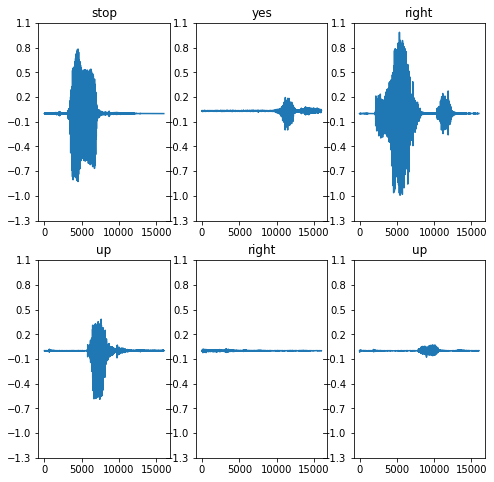

In [21]:
linhas = 2
colunas = 3
n = linhas * colunas
fig, axes = plt.subplots(linhas, colunas, figsize=(8, 8))
for i, (audio, rotulo) in enumerate(ondas_do_conjunto_treinamento.take(n)):
  l = i // colunas
  c = i % colunas
  ax = axes[l][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.3, 1.3, 0.3))
  rotulo = rotulo.numpy().decode('utf-8')
  ax.set_title(rotulo)
plt.show()

**Converter formas de onda em espectrogramas**

In [22]:
def obter_espectograma(onda):
  tamanho_entrada = 16000
  onda = onda[:tamanho_entrada]
  zero_padding = tf.zeros(
      [16000] - tf.shape(onda),
      dtype=tf.float32)
  onda = tf.cast(onda, dtype=tf.float32)
  comprimento_igual = tf.concat([onda, zero_padding], 0)  
  espectrograma = tf.signal.stft(
      comprimento_igual, frame_length=255, frame_step=128)
  espectrograma = tf.abs(espectrograma)
  espectrograma = espectrograma[..., tf.newaxis]
  return espectrograma

**explorar os dados**

In [23]:
for onda, rotulo in ondas_do_conjunto_treinamento.take(3):
  rotulo = rotulo.numpy().decode('utf-8')
  espectrograma = obter_espectograma(onda)
print('Rótulo: {}'.format(rotulo))
print('Formato da onda: {}'.format(onda.shape))
print('Formato do espectrograma: {}'.format(espectrograma.shape))
print('Prezado estudante, pressione o play para escutar o áudio.')
display.display(display.Audio(onda, rate=16000))

Rótulo: right
Formato da onda: (16000,)
Formato do espectrograma: (124, 129, 1)
Prezado estudante, pressione o play para escutar o áudio.


**função para exibir um espectrograma**

In [24]:
def grafico_espectrograma(espectrograma, ax):
  if len(espectrograma.shape) > 2:
    assert len(espectrograma.shape) == 3
    espectrograma = np.squeeze(espectrograma, axis=-1)
  log_espectograma = np.log(espectrograma.T + np.finfo(float).eps)
  altura = log_espectograma.shape[0]
  largura = log_espectograma.shape[1]
  X = np.linspace(0, np.size(log_espectograma), num=largura, dtype=int)
  Y = range(altura)
  ax.pcolormesh(X, Y, log_espectograma)

**Trace a forma de onda do exemplo ao longo do tempo e o espectrograma correspondente (frequências ao longo do tempo)**

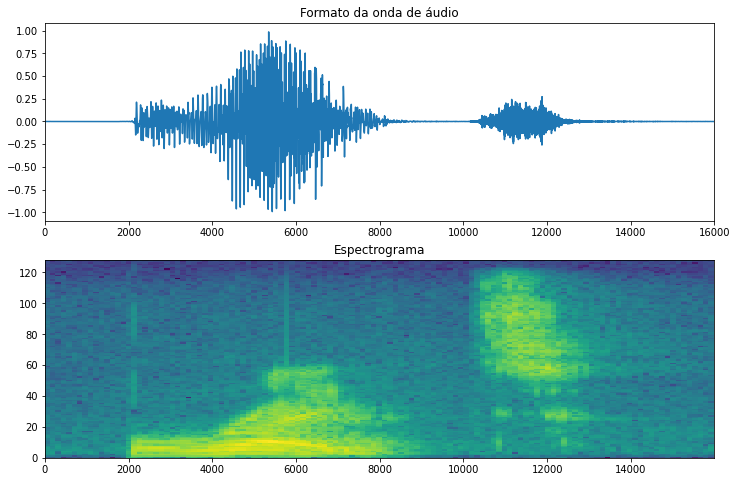

In [25]:
fig, axes = plt.subplots(2, figsize=(12, 8))
escala_de_tempo = np.arange(onda.shape[0])
axes[0].plot(escala_de_tempo, onda.numpy())
axes[0].set_title('Formato da onda de áudio')
axes[0].set_xlim([0, 16000])

grafico_espectrograma(espectrograma.numpy(), axes[1])
axes[1].set_title('Espectrograma')
plt.show()

**Defina uma função que transforma o conjunto de dados da forma de onda em espectrogramas e seus rótulos correspondentes como IDs inteiros:**

In [26]:
def obter_espectrograma_e_rotulo_id(audio, rotulo):
  espectrograma = obter_espectograma(audio)
  rotulo_id = tf.argmax(rotulo == comandos)
  return espectrograma, rotulo_id

**Mapa get_spectrogram_and_label_id através elementos do conjunto de dados com Dataset.map**

In [27]:
espectrograma_do_conjunto_treinamento = ondas_do_conjunto_treinamento.map(
  map_func=obter_espectrograma_e_rotulo_id,
  num_parallel_calls=AUTOTUNE)

**Construir e treinar o modelo**

In [28]:
def conjunto_de_dados_preprocessados(arquivos):
  arquivos_conjunto_de_treinamento = tf.data.Dataset.from_tensor_slices(arquivos)
  saida = arquivos_conjunto_de_treinamento.map(
      map_func=obter_onda_e_rotulo,
      num_parallel_calls=AUTOTUNE)
  saida = saida.map(
      map_func = obter_espectrograma_e_rotulo_id,
      num_parallel_calls = AUTOTUNE)
  return saida

In [29]:
treinamento = espectrograma_do_conjunto_treinamento
validacao = conjunto_de_dados_preprocessados(arquivos_validacao)
teste = conjunto_de_dados_preprocessados(arquivos_teste)

**Lote os conjuntos de treinamento e validação para o treinamento do modelo**

In [30]:
batch_size = 64
treinamento = treinamento.batch(batch_size)
validacao = validacao.batch(batch_size)

**Adicionar Dataset.cache e Dataset.prefetch operações para reduzir a latência de leitura durante o treinamento do modelo:**

In [31]:
treinamento = treinamento.cache().prefetch(AUTOTUNE)
validacao = validacao.cache().prefetch(AUTOTUNE)

**Para a Normalization camada, a sua adapt método teria primeiro de ser chamado os dados de treino a fim de calcular as estatísticas agregados (isto é, a média e o desvio padrão).**

In [32]:
for espectrograma, _ in espectrograma_do_conjunto_treinamento.take(1):
  formato_entrada = espectrograma.shape
print('Formato da entrada: {}'.format(formato_entrada))
num_rotulos = len(comandos)
camada_normalizada = layers.Normalization()
camada_normalizada.adapt(data=espectrograma_do_conjunto_treinamento.
                         map(map_func=lambda spec, label: spec))
modelo = models.Sequential([
    layers.Input(shape=formato_entrada),
    layers.Resizing(32, 32),    
    camada_normalizada,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_rotulos),
])

modelo.summary()

Formato da entrada: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)    

**Configure o modelo Keras com o otimizador Adam e a perda de entropia cruzada:**

In [33]:
modelo.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

**Treine o modelo em 10 épocas para fins de demonstração:**

In [34]:
EPOCAS = 100
historico = modelo.fit(
    treinamento,
    validation_data=validacao,
    epochs=EPOCAS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/100
100/100 [==============================] - 43s 414ms/step - loss: 1.7793 - accuracy: 0.3602 - val_loss: 1.3690 - val_accuracy: 0.5825
Epoch 2/100
100/100 [==============================] - 25s 248ms/step - loss: 1.2069 - accuracy: 0.5892 - val_loss: 0.9824 - val_accuracy: 0.6662
Epoch 3/100
100/100 [==============================] - 22s 223ms/step - loss: 0.9028 - accuracy: 0.6820 - val_loss: 0.8078 - val_accuracy: 0.7462
Epoch 4/100
100/100 [==============================] - 22s 224ms/step - loss: 0.7426 - accuracy: 0.7364 - val_loss: 0.7003 - val_accuracy: 0.7925
Epoch 5/100
100/100 [==============================] - 23s 226ms/step - loss: 0.6156 - accuracy: 0.7848 - val_loss: 0.6813 - val_accuracy: 0.8012
Epoch 6/100
100/100 [==============================] - 23s 226ms/step - loss: 0.5565 - accuracy: 0.8031 - val_loss: 0.6188 - val_accuracy: 0.8175
Epoch 7/100
100/100 [==============================] - 23s 229ms/step - loss: 0.4839 - accuracy: 0.8347 - val_loss: 0.6246 -

**Vamos plotar as curvas de perda de treinamento e validação para verificar como seu modelo melhorou durante o treinamento:**

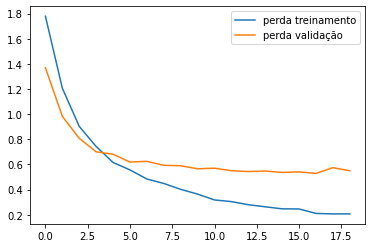

In [35]:
metricas = historico.history
plt.plot(historico.epoch, metricas['loss'], metricas['val_loss'])
plt.legend(['perda treinamento', 'perda validação'])
plt.show()

**Avalie o desempenho do modelo**

In [36]:
teste_audio = []
teste_rotulos = []
for audio, rotulo in teste:
  teste_audio.append(audio.numpy())
  teste_rotulos.append(rotulo.numpy())
teste_audio = np.array(teste_audio)
teste_rotulos = np.array(teste_rotulos)

In [37]:
y_pred = np.argmax(modelo.predict(teste_audio), axis=1)
y_real = teste_rotulos
teste_acuracia = sum(y_pred == y_real) / len(y_real)
print(f'Resultado do teste de acurácia: {teste_acuracia:.0%}')

Resultado do teste de acurácia: 85%


**Exibir uma matriz de confusão**

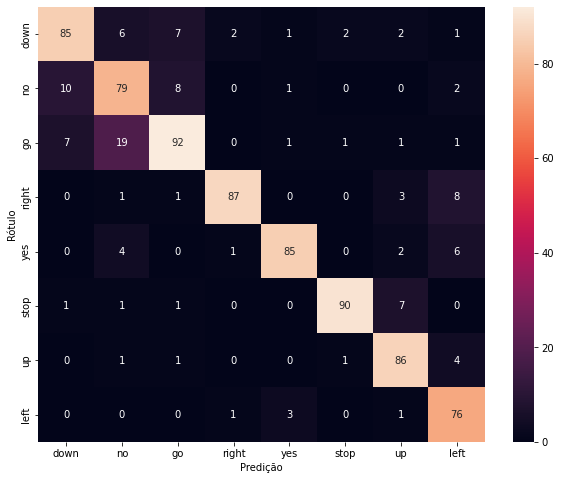

In [40]:
confusion_mtx = tf.math.confusion_matrix(y_real, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=comandos,
            yticklabels=comandos,
            annot=True, fmt='g')
plt.xlabel('Predição')
plt.ylabel('Rótulo')
plt.show()

**Executar inferência em um arquivo de áudio**

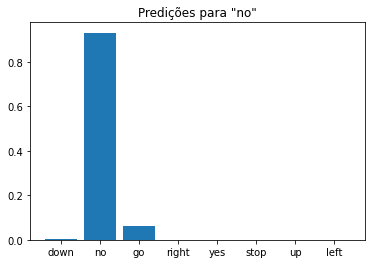

In [41]:
arquivo_de_amostra = dir_dados/'no/01bb6a2a_nohash_0.wav'
amostra = conjunto_de_dados_preprocessados([str(arquivo_de_amostra)])
for espectrograma, rotulo in amostra.batch(1):
  predicao = modelo(espectrograma)
  plt.bar(comandos, tf.nn.softmax(predicao[0]))
  plt.title(f'Predições para "{comandos[rotulo[0]]}"')
  plt.show()